Travail réalise par Muthulingam Aginth

# <center><u><font color='red'>Projet 5 : Segmentez des clients d'un site e-commerce</font></u></center>

## Chargement des modules 

In [2]:
import pandas as pd
import numpy as np
import random
import re
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import os
import datetime
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV , cross_validate
from sklearn.compose import make_column_selector, make_column_transformer , ColumnTransformer 
from category_encoders import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn import linear_model , metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score

## Importation des jeux de données

In [3]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
orders_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')

## Concatenation du dataset

In [4]:
ls_df = [customers,
geolocation,
orders,
orders_items,
order_payments,
order_reviews,
products,
sellers]

In [5]:
product_name = pd.read_csv('product_category_name_translation.csv')
print(product_name.shape)

(71, 2)


In [6]:
print(customers.shape)
print(geolocation.shape)
print(orders.shape)
print(orders_items.shape)
print(order_payments.shape)
print(order_reviews.shape)
print(products.shape)
print(sellers.shape)

(99441, 5)
(1000163, 5)
(99441, 8)
(112650, 7)
(103886, 5)
(99224, 7)
(32951, 9)
(3095, 4)


In [7]:
ls_nom = ['customers','geolocation','orders','orders_items','order_payments','order_reviews','products','sellers']

for i in range(len(ls_df)) :
    print(ls_nom[i])
    print(ls_df[i].columns.tolist())
    print()


customers
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

geolocation
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

orders
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

orders_items
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

order_payments
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

order_reviews
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

products
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_heigh

In [8]:
#merge 

order_merge1=pd.merge(orders,orders_items,on='order_id')
order_merge2=pd.merge(order_merge1,order_payments,on='order_id')
order_merge3=pd.merge(order_merge2,order_reviews,on='order_id')

dataset_merge1 = pd.merge(order_merge3,products,on='product_id')
dataset = pd.merge(dataset_merge1,customers,on='customer_id')
dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,1,0df37da38a30a713453b03053d60d3f7,...,1105.0,1.0,2800.0,28.0,23.0,23.0,fb9310710003399b031add3e55f34719,3318,sao paulo,SP
117325,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,2,0df37da38a30a713453b03053d60d3f7,...,1105.0,1.0,2800.0,28.0,23.0,23.0,fb9310710003399b031add3e55f34719,3318,sao paulo,SP
117326,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18 00:00:00,1,3d2c44374ee42b3003a470f3e937a2ea,...,372.0,2.0,300.0,16.0,6.0,12.0,a49e8e11e850592fe685ae3c64b40eca,83870,campo do tenente,PR
117327,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1,ac35486adb7b02598c182c2ff2e05254,...,1517.0,1.0,1175.0,22.0,13.0,18.0,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP


## Nettoyage du dataset 

###  <font color='blue'>Suppression des variables inutiles a l'analyse

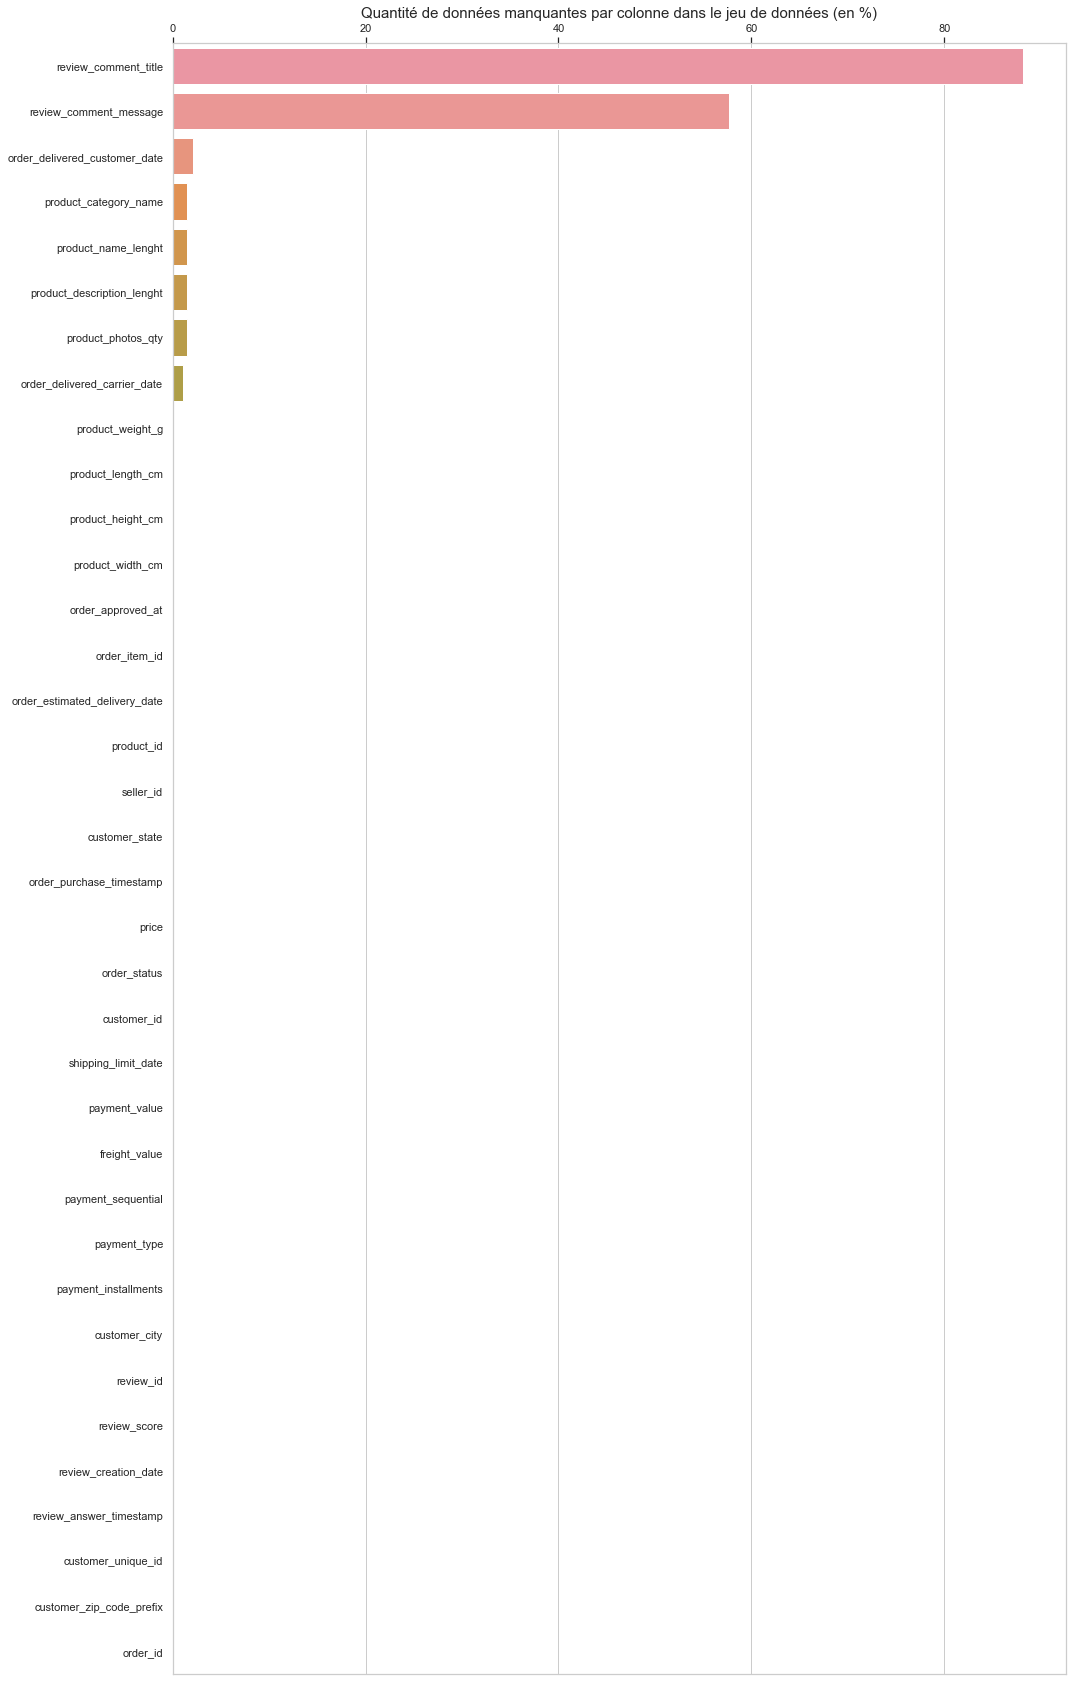

In [9]:
proportion_nan = dataset.isna().sum().divide(dataset.shape[0]/100).sort_values(ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(16, 30))
ax = sns.barplot(y = proportion_nan.index, x=proportion_nan.values)
ax.xaxis.set_ticks_position('top')
plt.title('Quantité de données manquantes par colonne dans le jeu de données (en %)', size=15)
plt.show()

In [10]:
#colonne à supprimer 
ls_drop = ['seller_id',
           'shipping_limit_date',
           'freight_value',
           'review_id',
           'review_comment_title',
           'product_photos_qty',
           'product_weight_g',
           'product_length_cm',
           'product_height_cm',
           'product_width_cm',
           'customer_zip_code_prefix',
           'payment_value'
]
#

In [11]:
dataset2=dataset.copy().drop(ls_drop,axis=1)

In [12]:
def suppression_dup (df):
    
    dataset = df.copy()
    df_dup = dataset.duplicated()
    print('Valeur dupliqué = ', len(df_dup[df_dup==True]))

    ind_dup = list(df_dup[df_dup==True].index)
    dataset =dataset.drop(ind_dup)
        
    return dataset

In [13]:
dataset3 = suppression_dup (dataset2)

Valeur dupliqué =  0


In [14]:
dataset3

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_score,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,...,4,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,...,5,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,1,0df37da38a30a713453b03053d60d3f7,...,4,NaN,2017-08-24 00:00:00,2017-08-25 11:38:19,esporte_lazer,53.0,1105.0,fb9310710003399b031add3e55f34719,sao paulo,SP
117325,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,2,0df37da38a30a713453b03053d60d3f7,...,4,NaN,2017-08-24 00:00:00,2017-08-25 11:38:19,esporte_lazer,53.0,1105.0,fb9310710003399b031add3e55f34719,sao paulo,SP
117326,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18 00:00:00,1,3d2c44374ee42b3003a470f3e937a2ea,...,1,"Ele não é um mini cajon, é um shaker, ou seja,...",2018-01-19 00:00:00,2018-01-21 02:51:39,instrumentos_musicais,34.0,372.0,a49e8e11e850592fe685ae3c64b40eca,campo do tenente,PR
117327,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1,ac35486adb7b02598c182c2ff2e05254,...,5,NaN,2017-03-22 00:00:00,2017-03-23 11:02:08,beleza_saude,50.0,1517.0,6359f309b166b0196dbf7ad2ac62bb5a,sao jose dos campos,SP


## Feature Enginnering

###  <font color='blue'>Creation de variable booléene pour le type de paiement

On cree une fonction permettant de creer une colonne pour chaque type de paiement utilise par commandes. Il existe 4 moyens
de paiement : 
    
    - carte de débit
    - carte de crédit
    - espèces
    - bon d'achats


In [15]:
def reunif_prix(df):
    new_df=df.copy()
    new_df=new_df.sort_values(['order_id','payment_sequential','order_item_id'],ascending=[True,False,False])
    
    
    for i in set(new_df['payment_type']):
        new_nom_pt = 'payment_type_'+i
        new_df[new_nom_pt]=0
    
    index_todrop=[]
    
    for i in list(set(new_df['order_id'])):
        df_i = new_df[new_df['order_id']==i]
        if len(df_i)>1:
            index_todrop += list(df_i.index[1:])
            
            payment = list(set(df_i['payment_type']))
            for j in payment :
                index=df_i.index[0]
                column= 'payment_type_'+j
                new_df[column][index]=1
                
        else :
            payment = list(set(df_i['payment_type']))
            index=df_i.index[0]
            column= 'payment_type_'+payment[0]
            new_df[column][index]=1
    
    new_df=new_df.drop(index_todrop)
    
        
    return new_df



In [16]:
s=reunif_prix(dataset3)

In [17]:
s=s[s['order_status']=='delivered']

In [18]:
dataset4=s.copy().drop(['payment_type'],axis=1)
dataset4['review_comment_message'].fillna("no com", inplace=True)
dataset4 = dataset4.dropna()

###  <font color='blue'>Creation de nouvelles variables 

On décide de creer 3 nouvelles variables :

   - différence delivery : il s'agit de la différence de temps entre le temps de livraison prévu et réeel. C'est une variable
    intérréssnte qui peut permettre d'évaluer le taux de satisfation d'un client
    
   - answers_time  : délai pour repondre au questionnaire de satisfaction envoyé au client. Variable permettant de voir si un 
    client est réactif et impliqué
    
   - recency : calcule de la récence, variable permettant de calculer la RFM 

In [68]:
def calcul_date(df):
    new_df=df.copy()
    df_time = df[['order_id','order_purchase_timestamp','order_delivered_customer_date',
                  'order_estimated_delivery_date','review_creation_date', 'review_answer_timestamp']].groupby([
        'order_id']).head()
    
    #Mise au format time des columns 
    
    df_time['order_purchase_timestamp'] = df_time['order_purchase_timestamp'].astype('datetime64')
    df_time['order_delivered_customer_date'] = pd.to_datetime(df_time['order_delivered_customer_date'], 
                                                                     errors='coerce')
    df_time['order_estimated_delivery_date'] = pd.to_datetime(df_time['order_estimated_delivery_date'], 
                                                                     errors='coerce')
    df_time['review_creation_date'] = pd.to_datetime(df_time['review_creation_date'], 
                                                                     errors='coerce')
    df_time['review_answer_timestamp'] = pd.to_datetime(df_time['review_answer_timestamp'], 
                                                                     errors='coerce')
    
    # Calcul 
    df_time['delivery_time'] = df_time['order_delivered_customer_date']- df_time[
        'order_purchase_timestamp']
    
    df_time['order_delivered_customer_date'] = [d.date() for d in df_time['order_delivered_customer_date']] 
    df_time['order_delivered_customer_date'] = pd.to_datetime(df_time['order_delivered_customer_date'], 
                                                                     errors='coerce')
    df_time['difference_delivery']= df_time['order_delivered_customer_date'] - df_time['order_estimated_delivery_date']
    
    df_time['answers_time'] = df_time['review_answer_timestamp'] - df_time['review_creation_date']

    # Calcul recence 
    df_time['order_purchase_timestamp'] = pd.to_datetime(df_time['order_purchase_timestamp'],errors='coerce')
    date_max = df_time['order_purchase_timestamp'].max()
    df_time['recency']= round((date_max - df_time['order_purchase_timestamp']) /np.timedelta64(1, 'h')/24)
    
    # Creation new_df 
    df_time = df_time.drop(['order_purchase_timestamp','order_delivered_customer_date',
                            'order_estimated_delivery_date','review_answer_timestamp',
                           'review_creation_date'],axis=1)

    new_df = pd.merge(new_df,df_time,on='order_id')
    new_df = new_df.drop(['order_delivered_customer_date','order_estimated_delivery_date',
                          'order_approved_at','order_delivered_carrier_date',
                          'review_creation_date','review_answer_timestamp'],axis=1)
    return new_df

In [69]:
dataset5 = calcul_date(dataset4)

In [70]:
dataset5

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,price,payment_sequential,payment_installments,review_score,...,customer_city,customer_state,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,delivery_time,difference_delivery,answers_time,recency
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,1,4244733e06e7ecb4970a6e2683c13e61,58.90,1,2,5,...,campos dos goytacazes,RJ,0,1,0,0,7 days 14:44:46,-9 days,1 days 10:57:03,350.0
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,1,e5f2d52b802189ee658865ca93d83a8f,239.90,1,3,4,...,santa fe do sul,SP,0,1,0,0,16 days 05:11:18,-3 days,2 days 11:34:13,490.0
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,1,c777355d18b72b67abbeef9df44fd0fd,199.00,1,5,5,...,para de minas,MG,0,1,0,0,7 days 22:45:45,-14 days,0 days 16:06:31,227.0
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,1,7634da152a4610f1595efa32f14722fc,12.99,1,2,4,...,atibaia,SP,0,1,0,0,6 days 03:32:04,-6 days,0 days 16:39:01,21.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,1,ac6c3623068f30de03045865e4e10089,199.90,1,3,5,...,varzea paulista,SP,0,1,0,0,25 days 02:44:40,-16 days,1 days 10:54:59,571.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94453,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,1,4aa6014eceb682077f9dc4bffebc05b0,299.99,1,1,5,...,sao luis,MA,1,0,0,0,17 days 08:59:34,-8 days,3 days 12:53:47,128.0
94454,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,1,32e07fd915822b0765e448c4dd74c828,350.00,1,1,5,...,curitiba,PR,1,0,0,0,9 days 10:05:09,-9 days,1 days 09:25:29,46.0
94455,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,1,72a30483855e2eafc67aee5dc2560482,99.90,1,3,5,...,sao paulo,SP,0,1,0,0,4 days 19:14:26,-13 days,0 days 21:33:52,310.0
94456,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,1,9c422a519119dcad7575db5af1ba540e,55.99,1,3,5,...,vinhedo,SP,0,1,0,0,1 days 22:56:41,-9 days,1 days 12:24:05,380.0


In [71]:
#Longueur des commentaires
dataset5['review_lenght']=dataset5['review_comment_message'].map(lambda x: len(x))
dataset6 = dataset5.copy().drop(['review_comment_message'],axis=1)
dataset6['order_purchase_timestamp'] = dataset6['order_purchase_timestamp'].astype('datetime64')

###  <font color='blue'>Creation d'une dataframe ou chaque ligne représente un client

In [88]:
#Creation d'une dataframe ou chaque ligne va correspondre à un clients uniques
def df_customers(df) :
    
    # ajout des variable nb d'achat, frequence achat et prix moyen
    
    price = df[['customer_unique_id','price']].groupby(['customer_unique_id']).mean()
    price = price.reset_index()
    
    nb_purch = df[['customer_unique_id','product_id']].groupby(['customer_unique_id']).count()
    nb_purch = nb_purch.rename(columns = {'product_id': 'nb_purchase'})
    nb_purch = nb_purch.reset_index()
    
    score = df[['customer_unique_id','review_score']].groupby(['customer_unique_id']).mean()
    score = score.reset_index()
    
    payment_inst = df[['customer_unique_id','payment_installments']].groupby(['customer_unique_id']).mean()
    payment_inst = payment_inst.reset_index()
    
    payment_seq = df[['customer_unique_id','payment_sequential']].groupby(['customer_unique_id']).mean()
    payment_seq = payment_seq.reset_index()

    city = df[['customer_unique_id','customer_city']].groupby(['customer_unique_id'])['customer_city'].apply(lambda x: x.mode()[0])
    city = pd.DataFrame(city)
    city = city.reset_index()
    
    state = df[['customer_unique_id','customer_state']].groupby([
        'customer_unique_id'])['customer_state'].apply(lambda x: x.mode()[0])
    state = pd.DataFrame(state)    
    state = state.reset_index() 
    
    order_date = df[['customer_unique_id','order_purchase_timestamp']].groupby(['customer_unique_id']).mean(numeric_only=False)
    order_date = order_date.rename(columns = {'order_purchase_timestamp': 'order_date'})
    order_date = order_date.reset_index()
        
    shp_days = df[['customer_unique_id','order_purchase_timestamp']].groupby(['customer_unique_id']).head(15)
    shp_days['order_purchase_timestamp'] = shp_days['order_purchase_timestamp'].astype('datetime64')
    shp_days['shop_days'] = shp_days['order_purchase_timestamp'].apply(lambda x: x.weekday())
    shp_days= shp_days.groupby(['customer_unique_id','shop_days']).count().sort_values(by=['order_purchase_timestamp'],ascending=True).groupby(level=0).tail(1)#.max(level=0)
    shp_days = shp_days.drop(['order_purchase_timestamp'],axis=1)
    shp_days = shp_days.reset_index() 
    
    
    shp_hour = df[['customer_unique_id','order_purchase_timestamp']].groupby(['customer_unique_id']).head(15)
    shp_hour['order_purchase_timestamp'] = shp_hour['order_purchase_timestamp'].astype('datetime64') 
    shp_hour['shop_hours'] = shp_hour['order_purchase_timestamp'].apply(lambda x: x.hour)
    shp_hour= shp_hour[['customer_unique_id','shop_hours']].groupby(['customer_unique_id']).mean(numeric_only=False)
    shp_hour = shp_hour.reset_index()

    delivery_t = df[['customer_unique_id','delivery_time']].groupby(['customer_unique_id']).mean(numeric_only=False)
    delivery_t = delivery_t.reset_index()

    delivery_diff = df[['customer_unique_id','difference_delivery']].groupby(['customer_unique_id']).mean(numeric_only=False)
    delivery_diff = delivery_diff.reset_index()
    
    answer_t = df[['customer_unique_id','answers_time']].groupby(['customer_unique_id']).mean(numeric_only=False)
    answer_t = answer_t.reset_index()
    
    answer_lenght = df[['customer_unique_id','review_lenght']].groupby(['customer_unique_id']).mean()
    answer_lenght = answer_lenght.reset_index()
    
    
    recency = df[['customer_unique_id','recency']].groupby(['customer_unique_id']).mean()
    recency = recency.reset_index()
    
    monetary = df[['customer_unique_id','price']].groupby(['customer_unique_id']).sum()
    monetary = monetary.reset_index()
    monetary = monetary.rename(columns = {'price': 'monetary'})


    new_df= price.merge(nb_purch)
    new_df=new_df.merge(city)
    new_df=new_df.merge(state)
    new_df=new_df.merge(order_date)
    new_df=new_df.merge(shp_days)
    new_df=new_df.merge(shp_hour)
    new_df=new_df.merge(delivery_t)
    new_df=new_df.merge(delivery_diff)
    new_df=new_df.merge(payment_inst)
    new_df=new_df.merge(payment_seq)
    new_df=new_df.merge(score)
    new_df=new_df.merge(answer_t)
    new_df=new_df.merge(answer_lenght)
    new_df=new_df.merge(recency)
    new_df=new_df.merge(monetary)


    new_df['shop_hours']=new_df['shop_hours'].astype(int)
    new_df['payment_installments']=new_df['payment_installments'].astype(int)
    new_df['payment_sequential']=new_df['payment_sequential'].astype(int)

    return new_df

In [89]:
dataset7=df_customers(dataset6)

In [90]:
dataset7

,customer_unique_id,price,nb_purchase,customer_city,customer_state,order_date,shop_days,shop_hours,delivery_time,difference_delivery,payment_installments,payment_sequential,review_score,answers_time,review_lenght,recency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,cajamar,SP,2018-05-10 10:56:27,3,10,6 days 09:52:10,-5 days,8,1,5.0,4 days 13:44:48,111.0,111.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,osasco,SP,2018-05-07 11:11:27,0,11,3 days 06:51:15,-5 days,1,1,4.0,0 days 22:29:25,6.0,114.0,18.90
2,0000f46a3911fa3c0805444483337064,69.00,1,sao jose,SC,2017-03-10 21:05:03,4,21,25 days 17:33:44,-2 days,8,1,3.0,1 days 01:19:44,6.0,537.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,belem,PA,2017-10-12 20:29:41,3,20,20 days 00:53:24,-12 days,4,1,4.0,1 days 00:17:51,12.0,321.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,sorocaba,SP,2017-11-14 19:45:42,1,19,13 days 03:23:14,-8 days,6,1,5.0,4 days 22:29:35,6.0,288.0,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,680.00,1,sanharo,PE,2017-06-08 21:00:36,3,21,27 days 12:21:24,-27 days,10,1,5.0,4 days 11:20:05,6.0,447.0,680.00
91449,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,feira de santana,BA,2017-12-10 20:07:56,6,20,30 days 02:20:24,-3 days,1,1,4.0,5 days 11:51:59,6.0,262.0,64.89
91450,ffff371b4d645b6ecea244b27531430a,89.90,1,sinop,MT,2017-02-07 15:49:16,1,15,14 days 20:55:48,-30 days,1,1,5.0,2 days 15:03:21,6.0,568.0,89.90
91451,ffff5962728ec6157033ef9805bacc48,115.00,1,bom jesus do norte,ES,2018-05-02 15:17:41,2,15,11 days 20:36:45,-14 days,5,1,5.0,2 days 15:16:20,133.0,119.0,115.00


###  <font color='blue'>Simplication de la colonne categorie

Il existe plus de 90 categories de produits. On décide donc de simplifier en regroupant plusieurs catégories

In [91]:
dict_cat = {
'Alimentation': ['alimentos_bebidas','alimentos','bebidas'],

'Hygiene': ['beleza_saude','perfumaria','bebes','fraldas_higiene'],

'Mode' : ['relogios_presentes','fashion_bolsas_e_acessorios','fashion_calcados',
'malas_acessorios','fashion_roupa_masculina','fashion_underwear_e_moda_praia',
'fashion_esporte','fashion_roupa_feminina','fashion_roupa_infanto_juvenil'],

'Maison' : ['cama_mesa_banho','moveis_decoracao','utilidades_domesticas',
'climatizacao','moveis_cozinha_area_de_servico_jantar_e_jardim',
'moveis_escritorio','casa_conforto','moveis_colchao_e_estofado',
'moveis_sala','moveis_quarto','la_cuisine','casa_conforto_2'],

'Bricolage' : ['ferramentas_jardim','construcao_ferramentas_construcao',
'construcao_ferramentas_jardim','construcao_ferramentas_ferramentas',
'casa_construcao','construcao_ferramentas_iluminacao',
'construcao_ferramentas_seguranca'] ,

'Loisirs' : ['esporte_lazer','papelaria','brinquedos','artigos_de_festas',
'livros_tecnicos','instrumentos_musicais','artes','livros_interesse_geral',
'artigos_de_natal','livros_importados','cine_foto','musica','cds_dvds_musicais',
'dvds_blu_ray','flores','artes_e_artesanato'],

'Electronique/Electromenager':['informatica_acessorios','telefonia',
'tablets_impressao_imagem','telefonia_fixa','eletroportateis','consoles_games',
'audio','eletronicos','eletrodomesticos','pcs','eletrodomesticos_2',
'portateis_casa_forno_e_cafe','pc_gamer','portateis_cozinha_e_preparadores_de_alimentos'],

'Securite': ['sinalizacao_e_seguranca','seguros_e_servicos'],

'Autres' : ['automotivo','cool_stuff','pet_shop','market_place',
'agro_industria_e_comercio','industria_comercio_e_negocios']

}

for i in dict_cat.keys():
    for j in dict_cat[i] : 
        dataset6.loc[dataset6['product_category_name']==j,'product_category_name']=i


In [92]:
def concat (data1,data2):
    df1 = data1.copy() ; df2 = data2.copy()
    df2=pd.merge(left=df2,right=pd.get_dummies(df2['product_category_name']),left_index=True,right_index=True)
    df2.drop(['product_category_name'],axis=1)
    
    ls_pay = ['payment_type_boleto','payment_type_debit_card','payment_type_voucher','payment_type_credit_card']
    ls = ls_pay+ list(pd.get_dummies(df2['product_category_name']).columns)
    

    
    
    
    df_purch = df1[df1['nb_purchase']>1]
    ls_id = list(df_purch['customer_unique_id'])
    df_ls = pd.DataFrame(np.zeros((len(ls_id),len(ls))),index=ls_id,columns=ls)
    for i in ls_id :
        #on regarde les cat
        zz=df2[df2['customer_unique_id']==i][ls]
        som=zz[zz>0].sum()
        ind=som[som>0].index
        for j in ind :
            df_ls[j][i]=1
    
    

    df2 = df2.set_index('customer_unique_id')
    df2 = df2[ls].drop(ls_id)
    df_cat = pd.concat([df2,df_ls],axis=0)
    
    df1 = df1.set_index('customer_unique_id')
    new_df=pd.concat([df1,df_cat],axis=1)

    return new_df

In [93]:
dataset8 = concat (dataset7,dataset6)

In [94]:
ls_cat = ['payment_type_boleto','payment_type_debit_card', 'payment_type_voucher',
'payment_type_credit_card','Alimentation','Autres','Bricolage','Electronique/Electromenager',
'Hygiene','Loisirs','Maison','Mode','Securite']

for i in ls_cat:
    dataset8[i]=dataset8[i].astype(bool)

###   <font color='blue'>Creation de la colonne RFM

In [95]:
nb_year=dataset6['order_purchase_timestamp'].max()-dataset6['order_purchase_timestamp'].min()
nb_year=round(nb_year/np.timedelta64(1, 'h')/24/365.25,2)
nb_year

1.9

In [96]:
def RFM (dataset,nb_year):
    new_df=dataset.copy()
    df_rfm=pd.DataFrame(np.zeros((len(new_df.index),3)),columns=['recency','frequency','monetary'],index=new_df.index)
    df_rfm['frequency']=round(new_df['nb_purchase']/nb_year)
    df_rfm['recency']=new_df['recency']
    df_rfm['monetary']=new_df['monetary']
    
    df_rfm['R_rank'] = df_rfm['recency'].rank(ascending=False)
    df_rfm['F_rank'] = df_rfm['frequency'].rank(ascending=True)
    df_rfm['M_rank'] = df_rfm['monetary'].rank(ascending=True)
 
    # normalizing the rank of the customers
    df_rfm['R_rank_norm'] = (df_rfm['R_rank']/df_rfm['R_rank'].max())*100
    df_rfm['F_rank_norm'] = (df_rfm['F_rank']/df_rfm['F_rank'].max())*100
    df_rfm['M_rank_norm'] = (df_rfm['M_rank']/df_rfm['M_rank'].max())*100
 
    df_rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
    
    df_rfm['RFM_Score'] = 0.15*df_rfm['R_rank_norm']+0.28 *df_rfm['F_rank_norm']+0.57*df_rfm['M_rank_norm']
    df_rfm['RFM_Score'] *= 0.05
    df_rfm = df_rfm.round(2)
    
    
    new_df.drop(columns=['monetary','recency'], inplace=True)
    new_df = pd.concat([new_df,df_rfm],axis=1)

    return new_df

In [98]:
dataset9=RFM (dataset8,nb_year)
dataset9

,price,nb_purchase,customer_city,customer_state,order_date,shop_days,shop_hours,delivery_time,difference_delivery,payment_installments,...,Maison,Mode,Securite,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,cajamar,SP,2018-05-10 10:56:27,3,10,6 days 09:52:10,-5 days,8,...,True,False,False,111.0,1.0,129.90,76.17,49.88,71.18,3.30
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,osasco,SP,2018-05-07 11:11:27,0,11,3 days 06:51:15,-5 days,1,...,False,False,False,114.0,1.0,18.90,75.14,49.88,5.10,1.41
0000f46a3911fa3c0805444483337064,69.00,1,sao jose,SC,2017-03-10 21:05:03,4,21,25 days 17:33:44,-2 days,8,...,False,False,False,537.0,1.0,69.00,3.42,49.88,43.25,1.96
0000f6ccb0745a6a4b88665a16c9f078,25.99,1,belem,PA,2017-10-12 20:29:41,3,20,20 days 00:53:24,-12 days,4,...,False,False,False,321.0,1.0,25.99,28.70,49.88,11.41,1.24
0004aac84e0df4da2b147fca70cf8255,180.00,1,sorocaba,SP,2017-11-14 19:45:42,1,19,13 days 03:23:14,-8 days,6,...,False,False,False,288.0,1.0,180.00,33.80,49.88,83.20,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,680.00,1,sanharo,PE,2017-06-08 21:00:36,3,21,27 days 12:21:24,-27 days,10,...,False,False,False,447.0,1.0,680.00,12.08,49.88,98.05,3.58
fffea47cd6d3cc0a88bd621562a9d061,64.89,1,feira de santana,BA,2017-12-10 20:07:56,6,20,30 days 02:20:24,-3 days,1,...,False,False,False,262.0,1.0,64.89,41.52,49.88,41.08,2.18
ffff371b4d645b6ecea244b27531430a,89.90,1,sinop,MT,2017-02-07 15:49:16,1,15,14 days 20:55:48,-30 days,1,...,False,False,False,568.0,1.0,89.90,1.46,49.88,54.69,2.27
ffff5962728ec6157033ef9805bacc48,115.00,1,bom jesus do norte,ES,2018-05-02 15:17:41,2,15,11 days 20:36:45,-14 days,5,...,False,True,False,119.0,1.0,115.00,73.79,49.88,65.84,3.13


In [99]:
## on convertit le format timedelta en int (en h)

In [100]:
dataset9['delivery_time'] = pd.to_timedelta(dataset9['delivery_time'], errors='coerce')
dataset9['difference_delivery'] = pd.to_timedelta(dataset9['difference_delivery'], errors='coerce')
dataset9['answers_time'] = pd.to_timedelta(dataset9['answers_time'], errors='coerce')


dataset9['delivery_time'] = dataset9['delivery_time']/ np.timedelta64(1, 'h')
dataset9['difference_delivery'] = dataset9['difference_delivery']/ np.timedelta64(1, 'h')
dataset9['answers_time'] = dataset9['answers_time']/ np.timedelta64(1, 'h')
dataset9['recency'] = dataset9['recency'] *24 # on passe en nb de jours à nb d'heure 


## Analyse

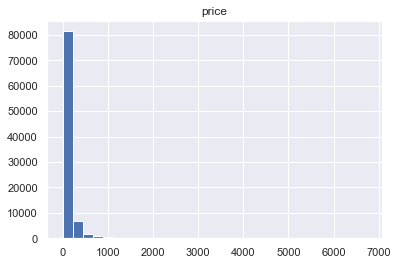

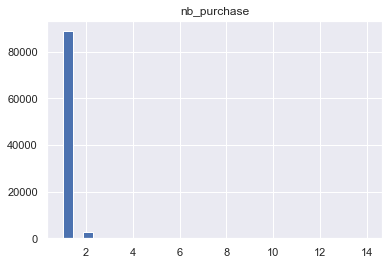

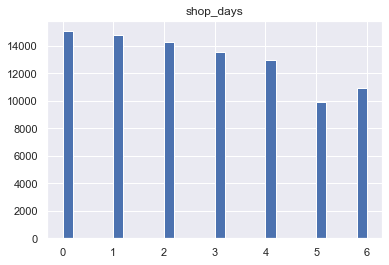

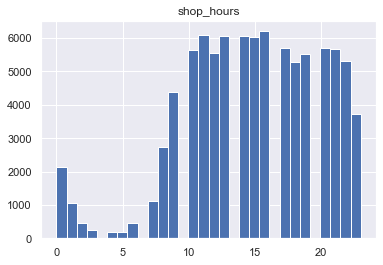

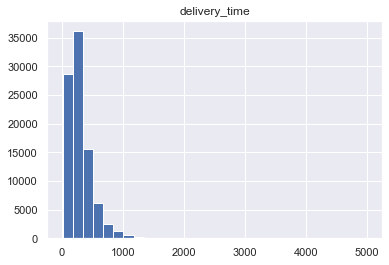

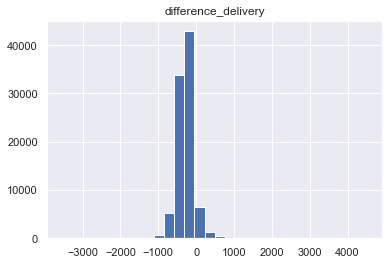

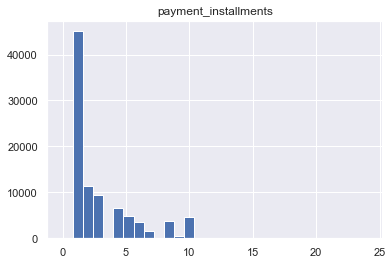

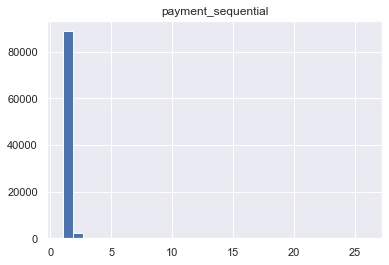

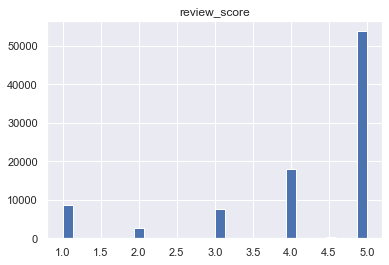

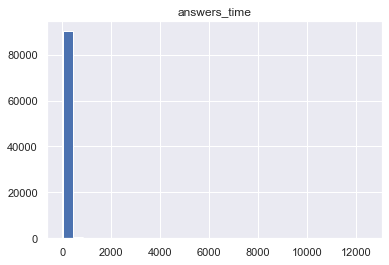

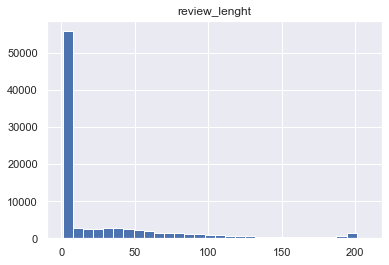

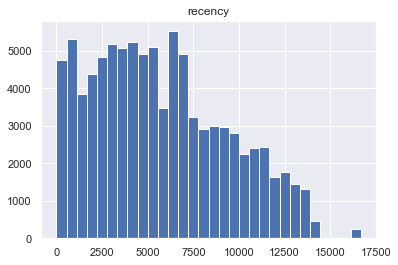

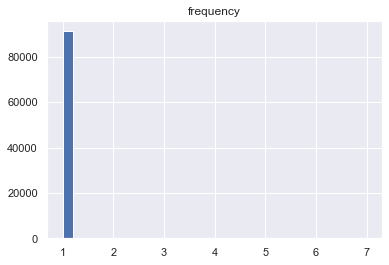

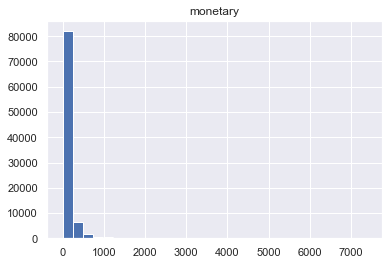

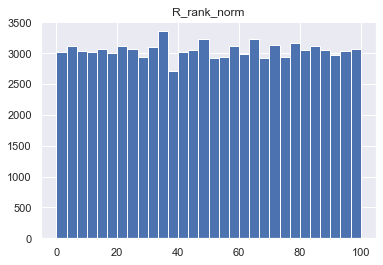

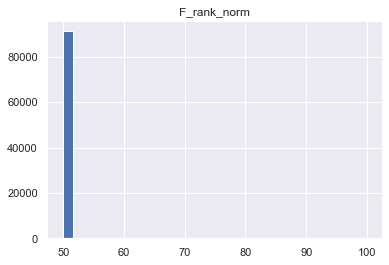

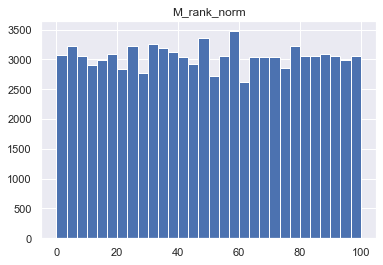

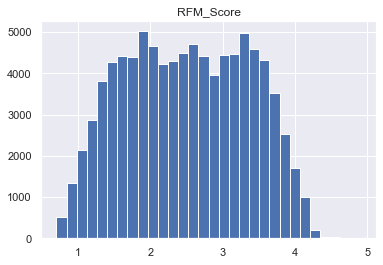

In [101]:
for col in dataset9.select_dtypes(include=['float64','int64','int32']):
    dataset9.hist(column=col,bins=30)

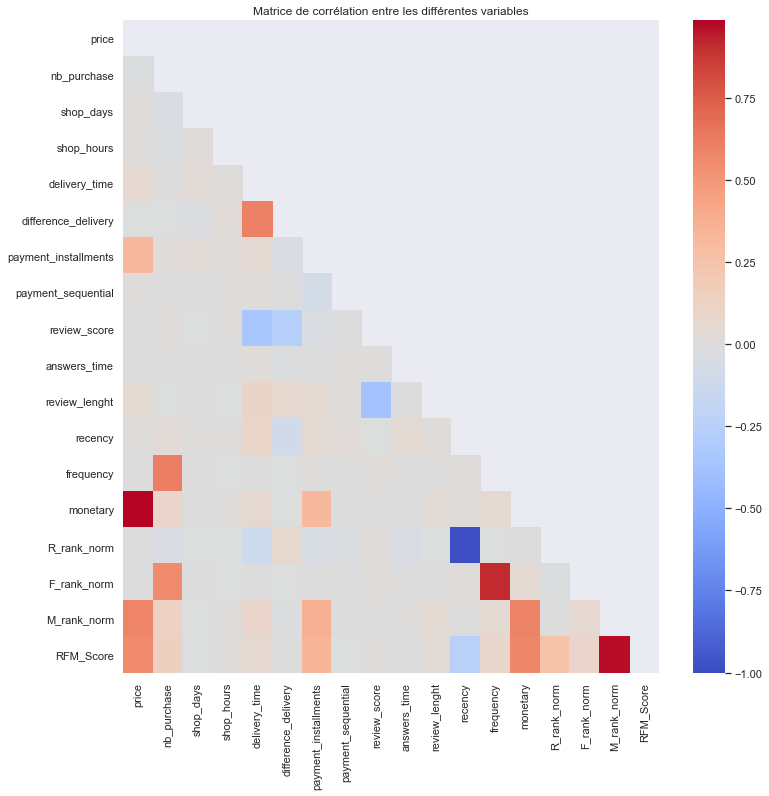

In [102]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1)
plt.title('Matrice de corrélation entre les différentes variables')

corr = dataset9.select_dtypes(include=['float64','int64','int32']).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

In [103]:
corr

,price,nb_purchase,shop_days,shop_hours,delivery_time,difference_delivery,payment_installments,payment_sequential,review_score,answers_time,review_lenght,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
price,1.000000,-0.016437,0.002201,0.007531,0.059924,-0.008111,0.315719,0.001479,-0.005581,-0.000336,0.040330,0.003101,-0.005921,0.986935,-0.000765,-0.006054,0.589035,0.567453
nb_purchase,-0.016437,1.000000,-0.031501,-0.018097,-0.005082,-0.013922,0.013628,-0.002437,0.010487,-0.003326,-0.008164,0.027641,0.608244,0.093285,-0.034148,0.556325,0.135706,0.144274
shop_days,0.002201,-0.031501,1.000000,0.011792,0.030656,-0.029735,0.024708,-0.000242,-0.011677,0.000987,-0.001517,0.007675,-0.003443,-0.001515,-0.009944,-0.002822,-0.008133,-0.010466
shop_hours,0.007531,-0.018097,0.011792,1.000000,0.003221,0.023047,0.013753,0.007570,0.003640,0.000589,-0.007664,0.008634,-0.008143,0.005386,-0.007483,-0.009445,0.008732,0.006127
delivery_time,0.059924,-0.005082,0.030656,0.003221,1.000000,0.602582,0.052326,0.005785,-0.336121,0.009466,0.109816,0.099553,-0.003706,0.058718,-0.116620,-0.003250,0.091907,0.058888
difference_delivery,-0.008111,-0.013922,-0.029735,0.023047,0.602582,1.000000,-0.029977,-0.003471,-0.268619,-0.014443,0.065780,-0.098455,-0.008133,-0.009516,0.069864,-0.010013,-0.019060,-0.001065
payment_installments,0.315719,0.013628,0.024708,0.013753,0.052326,-0.029977,1.000000,-0.077052,-0.031516,0.001147,0.041947,0.047504,0.001350,0.314191,-0.047221,0.001073,0.371200,0.345946
payment_sequential,0.001479,-0.002437,-0.000242,0.007570,0.005785,-0.003471,-0.077052,1.000000,-0.003287,0.002065,0.002729,0.023174,-0.001807,0.000645,-0.022267,-0.001511,-0.004646,-0.010189
review_score,-0.005581,0.010487,-0.011677,0.003640,-0.336121,-0.268619,-0.031516,-0.003287,1.000000,0.006924,-0.378741,-0.006583,0.009823,-0.004034,0.013196,0.010698,-0.000399,0.003398
answers_time,-0.000336,-0.003326,0.000987,0.000589,0.009466,-0.014443,0.001147,0.002065,0.006924,1.000000,-0.004054,0.042598,-0.001010,-0.000953,-0.039199,-0.000295,0.004622,-0.005505


In [104]:
dataset9.select_dtypes(include=['float64','int64','int32'])

,price,nb_purchase,shop_days,shop_hours,delivery_time,difference_delivery,payment_installments,payment_sequential,review_score,answers_time,review_lenght,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,3,10,153.869444,-120.0,8,1,5.0,109.746667,111.0,2664.0,1.0,129.90,76.17,49.88,71.18,3.30
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,0,11,78.854167,-120.0,1,1,4.0,22.490278,6.0,2736.0,1.0,18.90,75.14,49.88,5.10,1.41
0000f46a3911fa3c0805444483337064,69.00,1,4,21,617.562222,-48.0,8,1,3.0,25.328889,6.0,12888.0,1.0,69.00,3.42,49.88,43.25,1.96
0000f6ccb0745a6a4b88665a16c9f078,25.99,1,3,20,480.890000,-288.0,4,1,4.0,24.297500,12.0,7704.0,1.0,25.99,28.70,49.88,11.41,1.24
0004aac84e0df4da2b147fca70cf8255,180.00,1,1,19,315.387222,-192.0,6,1,5.0,118.493056,6.0,6912.0,1.0,180.00,33.80,49.88,83.20,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,680.00,1,3,21,660.356667,-648.0,10,1,5.0,107.334722,6.0,10728.0,1.0,680.00,12.08,49.88,98.05,3.58
fffea47cd6d3cc0a88bd621562a9d061,64.89,1,6,20,722.340000,-72.0,1,1,4.0,131.866389,6.0,6288.0,1.0,64.89,41.52,49.88,41.08,2.18
ffff371b4d645b6ecea244b27531430a,89.90,1,1,15,356.930000,-720.0,1,1,5.0,63.055833,6.0,13632.0,1.0,89.90,1.46,49.88,54.69,2.27
ffff5962728ec6157033ef9805bacc48,115.00,1,2,15,284.612500,-336.0,5,1,5.0,63.272222,133.0,2856.0,1.0,115.00,73.79,49.88,65.84,3.13


In [105]:
dataset9

,price,nb_purchase,customer_city,customer_state,order_date,shop_days,shop_hours,delivery_time,difference_delivery,payment_installments,...,Maison,Mode,Securite,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,cajamar,SP,2018-05-10 10:56:27,3,10,153.869444,-120.0,8,...,True,False,False,2664.0,1.0,129.90,76.17,49.88,71.18,3.30
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,osasco,SP,2018-05-07 11:11:27,0,11,78.854167,-120.0,1,...,False,False,False,2736.0,1.0,18.90,75.14,49.88,5.10,1.41
0000f46a3911fa3c0805444483337064,69.00,1,sao jose,SC,2017-03-10 21:05:03,4,21,617.562222,-48.0,8,...,False,False,False,12888.0,1.0,69.00,3.42,49.88,43.25,1.96
0000f6ccb0745a6a4b88665a16c9f078,25.99,1,belem,PA,2017-10-12 20:29:41,3,20,480.890000,-288.0,4,...,False,False,False,7704.0,1.0,25.99,28.70,49.88,11.41,1.24
0004aac84e0df4da2b147fca70cf8255,180.00,1,sorocaba,SP,2017-11-14 19:45:42,1,19,315.387222,-192.0,6,...,False,False,False,6912.0,1.0,180.00,33.80,49.88,83.20,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,680.00,1,sanharo,PE,2017-06-08 21:00:36,3,21,660.356667,-648.0,10,...,False,False,False,10728.0,1.0,680.00,12.08,49.88,98.05,3.58
fffea47cd6d3cc0a88bd621562a9d061,64.89,1,feira de santana,BA,2017-12-10 20:07:56,6,20,722.340000,-72.0,1,...,False,False,False,6288.0,1.0,64.89,41.52,49.88,41.08,2.18
ffff371b4d645b6ecea244b27531430a,89.90,1,sinop,MT,2017-02-07 15:49:16,1,15,356.930000,-720.0,1,...,False,False,False,13632.0,1.0,89.90,1.46,49.88,54.69,2.27
ffff5962728ec6157033ef9805bacc48,115.00,1,bom jesus do norte,ES,2018-05-02 15:17:41,2,15,284.612500,-336.0,5,...,False,True,False,2856.0,1.0,115.00,73.79,49.88,65.84,3.13


In [106]:
dataset9.to_csv ('dataset_cleane.csv', index = False, header=True)

In [40]:
##Mise en place Modèle